# Fuzzy String Matching at Scale

### Entity Resolution is Everywhere, and Sometimes All We Got Are Strings
![StringUrl](https://media.giphy.com/media/l3JDHiU3rdY4oBK3S/giphy.gif "string")  
More and more often, companies are blending data from different sources to enhance and enrich the value we are getting from the data. Central to this effort is the concept of entity resolution (or record linkage) to ensure that we are looking at the same record across multiple different sources. In some cases the records may have enough different types of information that can be used to build a probabilistic estimate on whether it is the same entity. In other cases, we may only be looking at one field, such as a name, and we need to decide whether it is enough of a match or not.

#### More Data = Need for Speed
Fuzzy string matching is not a new problem, and several algorithms are commonly employed (Levenshtein distance, Jaro–Winkler distance). However, given the growth in the number of data that are being matched, it is increasingly important to be able to perform this matching at scale. Instead of comparing every record to every possible match, we can employ a vectorized approach using Natural Language Processing (NLP) libraries that make this not only possible, but relatively painless in implementation.

#### TF-IDF Approach
I got excited about using the NLP toolkit for short string matching after reading about its success on [Chris van den Berg's Blog Post](https://bergvca.github.io/2017/10/14/super-fast-string-matching.html). TF-IDF stands for "term frequency-inverse document frequency" and is a common approach to measuring similarity/dissimilarity among documents in a corpus (a collection of documents). The TF-IDF calculations typically consist of the following steps:
1. *Pre-processing & Tokenization*: Perform any cleaning on the data (case conversion, removal of stopwords & punctuation) and convert each document into tokens. Although tokenization is typically performed at the word level, we have the flexibility to define a token at a lower level, such as an n-gram, which is more useful for short string matching since we might only have a few words in each string.
2. *Calculate the Term Frequency*: The purpose of this step is to determine which words define the document; words that appear more frequently are indicative of what the document's subject matter. For each document (a string in our case), calculate the frequency for each term (token) in the document and divide by the total number of terms in the document. If we define a token as an n-gram, we will calculate the frequency of each n-gram in our string.
  
$$TF(t) = (Number\:of\:times\:term\:t\:appears\:in\:a\:document) / (Total\:number\:of\:terms\:in\:the\:document)$$  

3. *Calculate the Inverse Document Frequency*: The purpose of this step is to calculate the appropriate *weight* for each term, depending on how often it appears across all documents. A term that appears in all the different documents will have a lower weight compared to a term that only appears in one of the documents. The idea is that a token that appears in all documents is less is less descriptive of any particular document compared to a token that appears in only one of the documents.  

$$IDF(t) = ln(Total number of documents / Number of documents with term t in it)$$

4. *Calculate the TF-IDF Weights for each token*: Multiply the term frequency with the inverse document frequency
5. *Calculate the Cosine Similarity*: Cosine similarity is often used to compare the similarity of two vectors (in this case TF-IDF values). As described by Chris van den Berg, data scientists at ING developed a custom library to make the cosine similarity calcualtions faster than the built-in sci-kit learn implementation, which you can read about more [here](https://medium.com/wbaa/https-medium-com-ingwbaa-boosting-selection-of-the-most-similar-entities-in-large-scale-datasets-450b3242e618). We will use this library for a faster cosine similarity calculation than the built-in scikit learn cosine_similarity function.



## Example: Matching Film Titles
Matching titles is a perfect use case, since in many cases there may not be much more than a name to use for matching and we need to find the best match against a medium-large data set. For this example, I will demonstrate the TF-IDF string matching approach by matching titles from the [MovieLens Kaggle dataset](https://www.kaggle.com/grouplens/movielens-latest-full#links.csv) to the [IMDB title dataset](https://www.imdb.com/interfaces/). The titles in the MovieLens dataset are very similar to the IMDB titles, with only a couple minor differences, as shown in the example below. The MovieLens Kaggle dataset is also ideal because it contains the IMDB Id key, which we can use to get the true match for every record to validate our best guess.

MovieLens Title: "Confessional, The (Confessionnal, Le) (1995)"  
IMDB Title: "The Confessional (1995)"	

The TF-IDF approach is well suited for matching movie titles, since there are some words contained in titles that we would consider more important for matching compared to others. Articles such as "The" and "A" are worth keeping around for matching, as opposed to being removed as a stopword&mdash;a common early step in the NLP process, since titles may differ by only an article word (eg. [The Batman](https://www.imdb.com/title/tt1877830) vs. [Batman](https://www.imdb.com/title/tt0096895)). However, we still want to place less weight on articles and other common words. For example, [Playmobil: The Movie](https://www.imdb.com/title/tt4199898) should be more similar to "Playmobil" than to [Deadwood: The Movie](https://www.imdb.com/title/tt4943998). As mentioned above, because TF-IDF takes into account the distinctness of tokens among different documents (here each title is a document), we get this benefit of variable weights.

### Code

For this specific exercise, my goal is to find the top candidate target (main title) for each of the MovieLens titles, and then compare that result with the true match. Building off of the work from Chris van den Berg's Blog Post, I created a python `StringMatch` class to handle the matching, with the following additional changes: 
- The class methods below are designed to take in two different lists (instead of matching within one list).
- I added an option to return as either a dictionary or dataframe.
- Instead of using a custom ngram function, I leverage sci-kit learn's built-in ngram tokenizer, which has padding for words less than three characters long.

In [6]:
# Load libraries
import re
import time
import operator

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import csr_matrix
import pandas as pd

import sparse_dot_topn.sparse_dot_topn as ct

In [7]:
class StringMatch():
    
    def __init__(self, source_names, target_names):
        self.source_names = source_names
        self.target_names = target_names
        self.ct_vect      = None
        self.tfidf_vect   = None
        self.vocab        = None
        self.sprse_mtx    = None
        
        
    def tokenize(self, analyzer='char_wb', n=3):
        '''
        Tokenizes the list of strings, based on the selected analyzer

        :param str analyzer: Type of analyzer ('char_wb', 'word'). Default is trigram
        :param str n: If using n-gram analyzer, the gram length
        '''
        # Create initial count vectorizer & fit it on both lists to get vocab
        self.ct_vect = CountVectorizer(analyzer=analyzer, ngram_range=(n, n))
        self.vocab   = self.ct_vect.fit(self.source_names + self.target_names).vocabulary_
        
        # Create tf-idf vectorizer
        self.tfidf_vect  = TfidfVectorizer(vocabulary=self.vocab, analyzer=analyzer, ngram_range=(n, n))
        
        
    def match(self, ntop=1, lower_bound=0, output_fmt='df'):
        '''
        Main match function. Default settings return only the top candidate for every source string.
        
        :param int ntop: The number of top-n candidates that should be returned
        :param float lower_bound: The lower-bound threshold for keeping a candidate, between 0-1.
                                   Default set to 0, so consider all canidates
        :param str output_fmt: The output format. Either dataframe ('df') or dict ('dict')
        '''
        self._awesome_cossim_top(ntop, lower_bound)
        
        if output_fmt == 'df':
            match_output = self._make_matchdf()
        elif output_fmt == 'dict':
            match_output = self._make_matchdict()
            
        return match_output
        
        
    def _awesome_cossim_top(self, ntop, lower_bound):
        ''' https://gist.github.com/ymwdalex/5c363ddc1af447a9ff0b58ba14828fd6#file-awesome_sparse_dot_top-py '''
        # To CSR Matrix, if needed
        A = self.tfidf_vect.fit_transform(self.source_names).tocsr()
        B = self.tfidf_vect.fit_transform(self.target_names).transpose().tocsr()
        M, _ = A.shape
        _, N = B.shape

        idx_dtype = np.int32

        nnz_max = M * ntop

        indptr = np.zeros(M+1, dtype=idx_dtype)
        indices = np.zeros(nnz_max, dtype=idx_dtype)
        data = np.zeros(nnz_max, dtype=A.dtype)

        ct.sparse_dot_topn(
            M, N, np.asarray(A.indptr, dtype=idx_dtype),
            np.asarray(A.indices, dtype=idx_dtype),
            A.data,
            np.asarray(B.indptr, dtype=idx_dtype),
            np.asarray(B.indices, dtype=idx_dtype),
            B.data,
            ntop,
            lower_bound,
            indptr, indices, data)

        self.sprse_mtx = csr_matrix((data,indices,indptr), shape=(M,N))
    
    
    def _make_matchdf(self):
        ''' Build dataframe for result return '''
        # CSR matrix -> COO matrix
        cx = self.sprse_mtx.tocoo()

        # COO matrix to list of tuples
        match_list = []
        for row,col,val in zip(cx.row, cx.col, cx.data):
            match_list.append((row, self.source_names[row], col, self.target_names[col], val))

        # List of tuples to dataframe
        colnames = ['Row Idx', 'Title', 'Candidate Idx', 'Candidate Title', 'Score']
        match_df = pd.DataFrame(match_list, columns=colnames)

        return match_df

    
    def _make_matchdict(self):
        ''' Build dictionary for result return '''
        # CSR matrix -> COO matrix
        cx = self.sprse_mtx.tocoo()

        # dict value should be tuple of values
        match_dict = {}
        for row,col,val in zip(cx.row, cx.col, cx.data):
            if match_dict.get(row):
                match_dict[row].append((col,val))
            else:
                match_dict[row] = [(col, val)]

        return match_dict   

Now that we have the `StringMatch` class, we can run the matching algorithm using just a few lines of code (with default arguments):
```
titlematch = StringMatch(source_titles, target_titles)
titlematch.tokenize()
match_df = titlematch.match()
```
Let's take a look at how well it performs.

In [8]:
# Import IMDB Main Titles, filtering for movies
imdb_data = pd.read_csv('data/title_basics.tsv', sep='\t')
imdb_data.titleType.unique()
imdb_data = (imdb_data
             .dropna(subset=['primaryTitle'])
             .query('titleType in ("video", "tvMovie", "movie")')
             .assign(title=imdb_data.primaryTitle + ' (' + imdb_data.startYear.astype(str) + ')'))

In [9]:
# How big is the target dataset?
print(f"There are {len(imdb_data.index)} titles in the target dataset")

# View the table head
imdb_data.head()

There are 868517 titles in the target dataset


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,title
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,Miss Jerry (1894)
145,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,20,"Documentary,News,Sport",The Corbett-Fitzsimmons Fight (1897)
332,tt0000335,movie,Soldiers of the Cross,Soldiers of the Cross,0,1900,\N,\N,"Biography,Drama",Soldiers of the Cross (1900)
499,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,Bohemios (1905)
571,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Biography,Crime,Drama",The Story of the Kelly Gang (1906)


In [10]:
# Source of MovieLens Movie Title List
# https://www.kaggle.com/grouplens/movielens-latest-full

# Load the MovieLens Dataset & filter for latin characters
mvlens_ttl = pd.read_csv('data/movies.csv')
mvlens_links = pd.read_csv('data/links.csv')

# Join MovieLens titles to links
mvlens_ttl_j = (mvlens_ttl
                # Remove titles without latin characters
                .assign(title=mvlens_ttl.title.apply(lambda x: x.encode('ascii', 'ignore').decode('utf-8').strip()))
                .query('title != ""')
                # Join to links for IMDB Id SOT
                .merge(mvlens_links, how='inner', on='movieId')
               )


# How big is the source dataset?
print(f"There are {len(mvlens_ttl_j.index)} titles in the source dataset")

# Tweak imdbid formatting for join later
mvlens_ttl_j.imdbId = mvlens_ttl_j.imdbId.apply(lambda x: 'tt' + str(x).zfill(7))

# Get list of Titles and IDs
mvlens_ttl_list = mvlens_ttl_j.title.tolist()
mvlens_id_list  = mvlens_ttl_j.movieId.tolist()

# Let's take a look at the combined MovieLens table
mvlens_ttl_j.head()

There are 58094 titles in the source dataset


,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,tt0114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,tt0113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,tt0113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,tt0114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,tt0113041,11862.0


In [12]:
from datetime import datetime

pd.set_option('display.max_rows', 1000)

# Get list of Primary Titles and IDs
imdb_ttl_list = imdb_data.title.tolist()
imdb_id_list  = imdb_data.tconst.tolist()
imdb_ttl_dict = dict(zip(imdb_id_list, imdb_ttl_list))

# Match the MvLens titles to IMDB titles (and time it)
t0 = datetime.now()
titlematch = StringMatch(mvlens_ttl_list, imdb_ttl_list)
titlematch.tokenize()
match_df = titlematch.match()
t1 = datetime.now()
full_time_tfidf = (t1-t0).total_seconds()

# Small formatting changes & merge w/ SOT
match_df = (match_df
            # Attach the IMDB Id for the MVLens
            .assign(mvlens_id=mvlens_id_list)
            # Lookup & attach the IMDB for the top candidate title
            .assign(candidate_imdb_id=match_df['Candidate Idx'].apply(lambda x: imdb_id_list[x]))
            #  Join to SOT - Main Titles
            .merge(mvlens_ttl_j, left_on='mvlens_id', right_on='movieId')
            # Drop unnecessary columns
            .drop(columns=['movieId', 'title', 'genres', 'tmdbId']))

# Modify the merged df
match_df = (match_df
            # Add actual IMDB Title, using the key provided by MovieLens
            .assign(imdbTitle=match_df.imdbId.apply(lambda x: imdb_ttl_dict.get(x)))
            # Compare candidate IMDB Id w/ actual title IMDB Id for accuracy calculation
            .assign(acc=np.where(match_df.candidate_imdb_id == match_df.imdbId, 1, 0)))


### Performance: Speed
This is where the TF-IDF method really shines. The code below includes the function to run the Levenshtein Distance algorithm using Python's fuzzywuzzy package, as well as a small function I built to time how long it takes to match a randomly sampled set of titles. The chart below shows the incredible difference between the Levenshtein Distance algorithm (through Python's fuzzywuzzy package), and the TF-IDF approach advocated for here.

In [13]:

from random import sample 
from fuzzywuzzy import process

def match_names_fuzzywuzzy(source_list, target_list):
    
    name_match=[]
    ratio_match=[]

    for row in source_list:
        x = process.extractOne(row, target_list)
        name_match.append(x[0])
        ratio_match.append(x[1])
        
    df = pd.DataFrame(list(zip(source_list, name_match, ratio_match)), 
               columns =['Source Title', 'Candidate Title', 'Score']) 
    return df


def time_match_sample(source, target, sample_size, type='tfidf'):
    '''
    Time the match process on a sample of data, using both the tf-idf and fuzzywuzzy process.

    :param list source: A list of strings to match
    :param list target: A list of strings to match to
    :param int sample_size: The number of items that should be sampled from the source; if None, then use all
    :param str type: The type of analysis ('tfidf' or 'lev')
    
    Returns: A tuple with the time (sec) to process the match (tf-idf, fuzzywuzzy)
    '''
    
    # Sample the source input, unless None
    sample_idx = sample(range(0, len(source)), sample_size)
    source_sample = [source[i] for i in sample_idx]
    if not sample_size:
        source_sampe = source
    
    # Start timer
    t0 = datetime.now()
    
    # Run TF-IDF
    if type == 'tfidf':
        titlematch = StringMatch(source_sample, target)
        titlematch.tokenize()
        match_df = titlematch.match()
    
    # Fuzzywuzzy implmentation
    elif type == 'lev':
        df_fuzzywuzzy = match_names_fuzzywuzzy(source_sample, target)
    
    # End the timer
    t1 = datetime.now()
    
    print("Complete.")
    return ((t1-t0).total_seconds())
    

In [15]:
# Time the runs for each method at different sample sizes
sample_1_lv    = time_match_sample(mvlens_ttl_list, imdb_ttl_list, 1, 'lev')
sample_5_lv    = time_match_sample(mvlens_ttl_list, imdb_ttl_list, 5, 'lev')
sample_10_lv   = time_match_sample(mvlens_ttl_list, imdb_ttl_list, 10, 'lev')

sample_1_tfidf = time_match_sample(mvlens_ttl_list, imdb_ttl_list, 1, 'tfidf')
sample_5_tfidf = time_match_sample(mvlens_ttl_list, imdb_ttl_list, 5, 'tfidf')
sample_10_tfidf = time_match_sample(mvlens_ttl_list, imdb_ttl_list, 10, 'tfidf')

sample_100_tfidf  = time_match_sample(mvlens_ttl_list, imdb_ttl_list, 100, 'tfidf')
sample_1000_tfidf = time_match_sample(mvlens_ttl_list, imdb_ttl_list, 1000, 'tfidf')

Complete.
Complete.
Complete.
Complete.
Complete.
Complete.
Complete.
Complete.


In [27]:
data = [
    ('Levenshtein', 1, sample_1_lv),
    ('Levenshtein', 5, sample_5_lv),
    ('Levenshtein', 10, sample_10_lv),
    ('TF-IDF', 1, sample_1_tfidf),
    ('TF-IDF', 5, sample_5_tfidf),
    ('TF-IDF', 100, sample_100_tfidf),
    ('TF-IDF', 1000, sample_1000_tfidf),
    ('TF-IDF', 58094, full_time_tfidf)
]
time_df = pd.DataFrame(data, columns=['Method', 'Size (n)', 'Time (s)'])

# Let's see the final df of run times
time_df

,Method,Size (n),Time (s)
0,Levenshtein,1,90.484227
1,Levenshtein,5,318.541885
2,Levenshtein,10,465.783670
3,TF-IDF,1,36.740275
4,TF-IDF,5,35.395367
5,TF-IDF,100,36.491493
6,TF-IDF,1000,52.127635
7,TF-IDF,58094,1117.652738


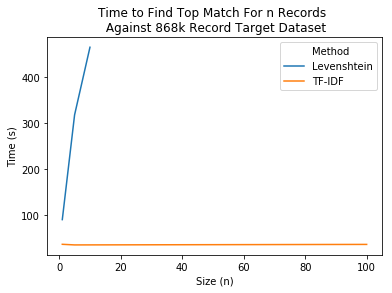

In [40]:
import seaborn as sns

# Plot time for sample sizes 1-100
ax = (sns.lineplot(x='Size (n)', 
                  y='Time (s)', 
                  hue='Method', 
                  data=time_df[time_df['Size (n)'] < 101])
        .set_title('Time to Find Top Match For n Records \n Against 868k Record Target Dataset'))
fig = ax.get_figure()
fig.savefig("MatchTime1.png")

Below is a zoomed out plot that includes the time it took to find all 

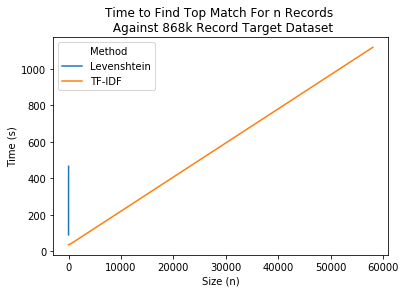

In [41]:
# Plot for the all the timed sets
ax = (sns.lineplot(x='Size (n)', y='Time (s)', hue='Method', data=time_df)
         .set_title('Time to Find Top Match For n Records \n Against 868k Record Target Dataset'))
fig = ax.get_figure()
fig.savefig("MatchTime2.png")

### Performance: Accuracy
How accurate was our match process? 

In [42]:
print(f"The true positive match rate is {match_df.acc.sum() / len(match_df.index)}")

The true positive match rate is 0.8308775432919062


Getting over 83% correct matches is not bad right off the bat, but I wanted to look further at the mismatches. The table below, showing the first twenty mismatches, shows in 9 cases (45 percent), the title matching algorithm picked a title that had the exact same name and year as the correct title. In these cases, it is not that the string matching is failing, but instead that the string matching is not enough when there are two candidate titles with the exact same name and year; If we wanted to go further, we'd need more information to differentiate the titles.

The weakness seems to be with the AKA titles, shown in parentheses as part of the MovieLens titles. I kept the alternate titles in the matching process because occassionaly the alternate MovieLens title is the main IMDB title. However, as shown in the table below, having both as part of the same string can sometimes muddy the water (example: _Ready to Wear (Pret-A-Porter) (1994)_). A better strategy would be to perform the string matching on both the main title and AKA title independently, and then pick the one with the best score.

In [43]:
match_df[match_df["acc"] == 0].head(20)

,Row Idx,Title,Candidate Idx,Candidate Title,Score,mvlens_id,candidate_imdb_id,imdbId,imdbTitle,acc
27,27,Persuasion (1995),96603,Persuasion (1995),0.999347,28,tt0127104,tt0114117,None,0
29,29,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,792281,Yao (2018),0.643999,30,tt8058904,tt0115012,Shanghai Triad (1995),0
47,47,Pocahontas (1995),834573,Pocahontas (1995),0.999280,48,tt9047432,tt0114148,Pocahontas (1995),0
67,67,French Twist (Gazon maudit) (1995),94813,French Twist (1995),0.627757,68,tt0124618,tt0113149,French Twist (1995),0
94,94,In the Bleak Midwinter (1995),668900,Holst: In the Bleak Midwinter (2011),0.742704,96,tt5517764,tt0113403,A Midwinter's Tale (1995),0
106,106,Catwalk (1996),94065,Catwalk (1995),0.841057,108,tt0123640,tt0112646,Catwalk (1995),0
138,138,Up Close and Personal (1996),118515,Up Close and Personal 4 (1996),0.967429,140,tt0161048,tt0118055,Up Close & Personal (1996),0
140,140,Shadows (Cienie) (1988),73076,Out of the Shadows (1988),0.591824,142,tt0095804,tt0094878,Cienie (1988),0
148,148,Apollo 13 (1995),722744,Apollo 13 (1995),0.999561,150,tt6590506,tt0112384,Apollo 13 (1995),0
185,185,Party Girl (1995),96584,Party Girl (1995),0.999600,187,tt0127082,tt0114095,Party Girl (1995),0


I would like to have done an accuracy comparison with the Levenshtein Distance formula using Python's `fuzzywuzzy` package, but, as shown above in the chart, it would simply have taken too much time, which is why I recommend using the TF-IDF approach for data at any serious scale. 

#### Attribution
MovieLens Data Source: https://www.kaggle.com/grouplens/movielens-latest-full#links.csv 

IMDB Data Source: https://www.imdb.com/interfaces/  
Information courtesy of IMDb (http://www.imdb.com).  
Used with permission.